### Initialization of Libraries

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
#For feature selection
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


## Import of Dataset

In [152]:
#Import Data
factory_df=pd.read_csv('factory_data.csv')
factory_df.head()

#could check on how many unique IDs 

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


## Data Preprocessing and Data Cleaning

1. Check on the missing values
2. Fill up the missing values
3. Encode the catergorical features

In [155]:
#check the dtype
print(factory_df.info())

#target variable: machine status

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             20000 non-null  int64  
 1   Product ID            20000 non-null  object 
 2   Quality               19009 non-null  object 
 3   Ambient T (C)         20000 non-null  float64
 4   Process T (C)         19600 non-null  float64
 5   Rotation Speed (rpm)  18812 non-null  float64
 6   Torque (Nm)           20000 non-null  float64
 7   Tool Wear (min)       20000 non-null  int64  
 8   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.4+ MB
None


In [157]:
#check for missing values
print(factory_df.isna().sum().sort_values())

Unique ID                  0
Product ID                 0
Ambient T (C)              0
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
Process T (C)            400
Quality                  991
Rotation Speed (rpm)    1188
dtype: int64


# Quality Column has been impute with the most frequent value
# Process and Rotation Speed impute with median
# Quality encoded into numerical values
# Product ID encoded using frequency encoding, which ID is being replaced by the number of occurence in the dataset 

In [159]:
#Data Preprocessing - Cleaning of data/filling up missing data

# Duplicate factory data safely
factory_df_clean = factory_df.copy()

# Fill missing values
# Categorical: 'Quality' - fill with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
factory_df_clean[['Quality']] = cat_imputer.fit_transform(factory_df_clean[['Quality']])

# Numerical columns - fill with median
num_imputer = SimpleImputer(strategy='median')
factory_df_clean[['Process T (C)', 'Rotation Speed (rpm)']] = num_imputer.fit_transform(
    factory_df_clean[['Process T (C)', 'Rotation Speed (rpm)']])

# Encode 'Quality' (L=0, M=1, H=2)
quality_mapping = {'L': 0, 'M': 1, 'H': 2}
factory_df_clean['Quality'] = factory_df_clean['Quality'].map(quality_mapping)

# Encode 'Product ID' using frequency encoding
product_freq = factory_df_clean['Product ID'].value_counts().to_dict()
factory_df_clean['Product ID'] = factory_df_clean['Product ID'].map(product_freq)

# Check the cleaned data
factory_df_clean.info(), factory_df_clean.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             20000 non-null  int64  
 1   Product ID            20000 non-null  int64  
 2   Quality               20000 non-null  int64  
 3   Ambient T (C)         20000 non-null  float64
 4   Process T (C)         20000 non-null  float64
 5   Rotation Speed (rpm)  20000 non-null  float64
 6   Torque (Nm)           20000 non-null  float64
 7   Tool Wear (min)       20000 non-null  int64  
 8   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.4 MB


(None,
    Unique ID  Product ID  Quality  Ambient T (C)  Process T (C)  \
 0          1           1        1          24.95          35.45   
 1          2           1        0          25.05          35.55   
 2          3           1        0          24.95          35.35   
 3          4           1        0          25.05          35.45   
 4          5           2        0          25.05          35.55   
 
    Rotation Speed (rpm)  Torque (Nm)  Tool Wear (min)  Machine Status  
 0                1551.0         42.8                0               0  
 1                1408.0         46.3                3               0  
 2                1498.0         49.4                5               0  
 3                1433.0         39.5                7               0  
 4                1408.0         40.0                9               0  )

In [161]:
#double check to see if there are any missing values
print(factory_df_clean.isna().sum().sort_values())

Unique ID               0
Product ID              0
Quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
Machine Status          0
dtype: int64


## Exploratory Data Analysis

Correlation Heatmap
Helps to visualise how features are correlated with each other. 

Strong CorrelationsL
Ambient T (C) and Process T (C) - could suggest potential redundancy and could remove either one of them during feature selection 


Pairplot Observations
The pairplot shows how individual features relate to the target variable (Machine Status). Features that show clear separation between the two classes (e.g., Rotation Speed (rpm), Torque (Nm)) are good candidates for classification. Features with overlapping distributions between classes might not be as useful for classification.


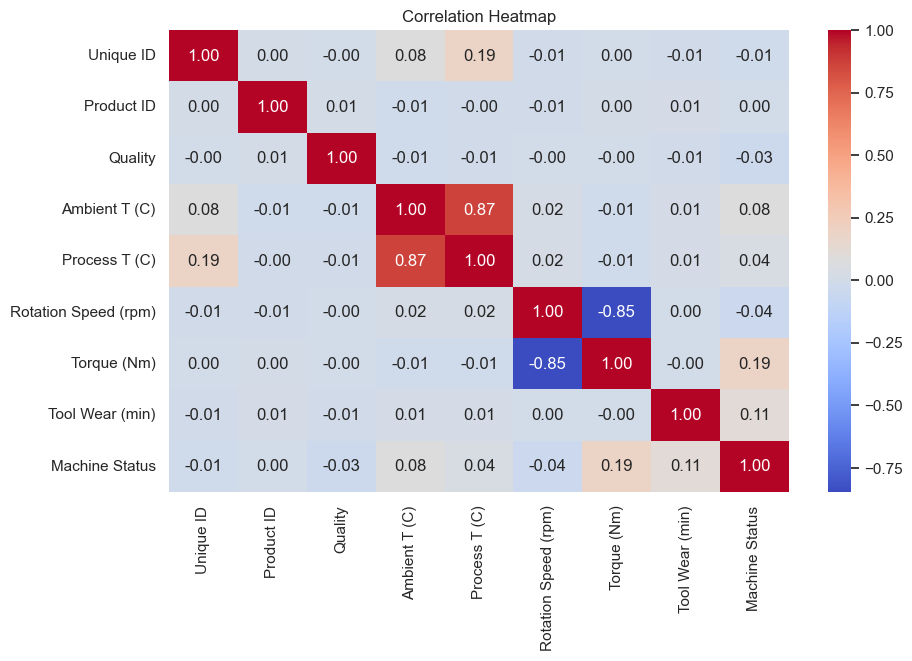

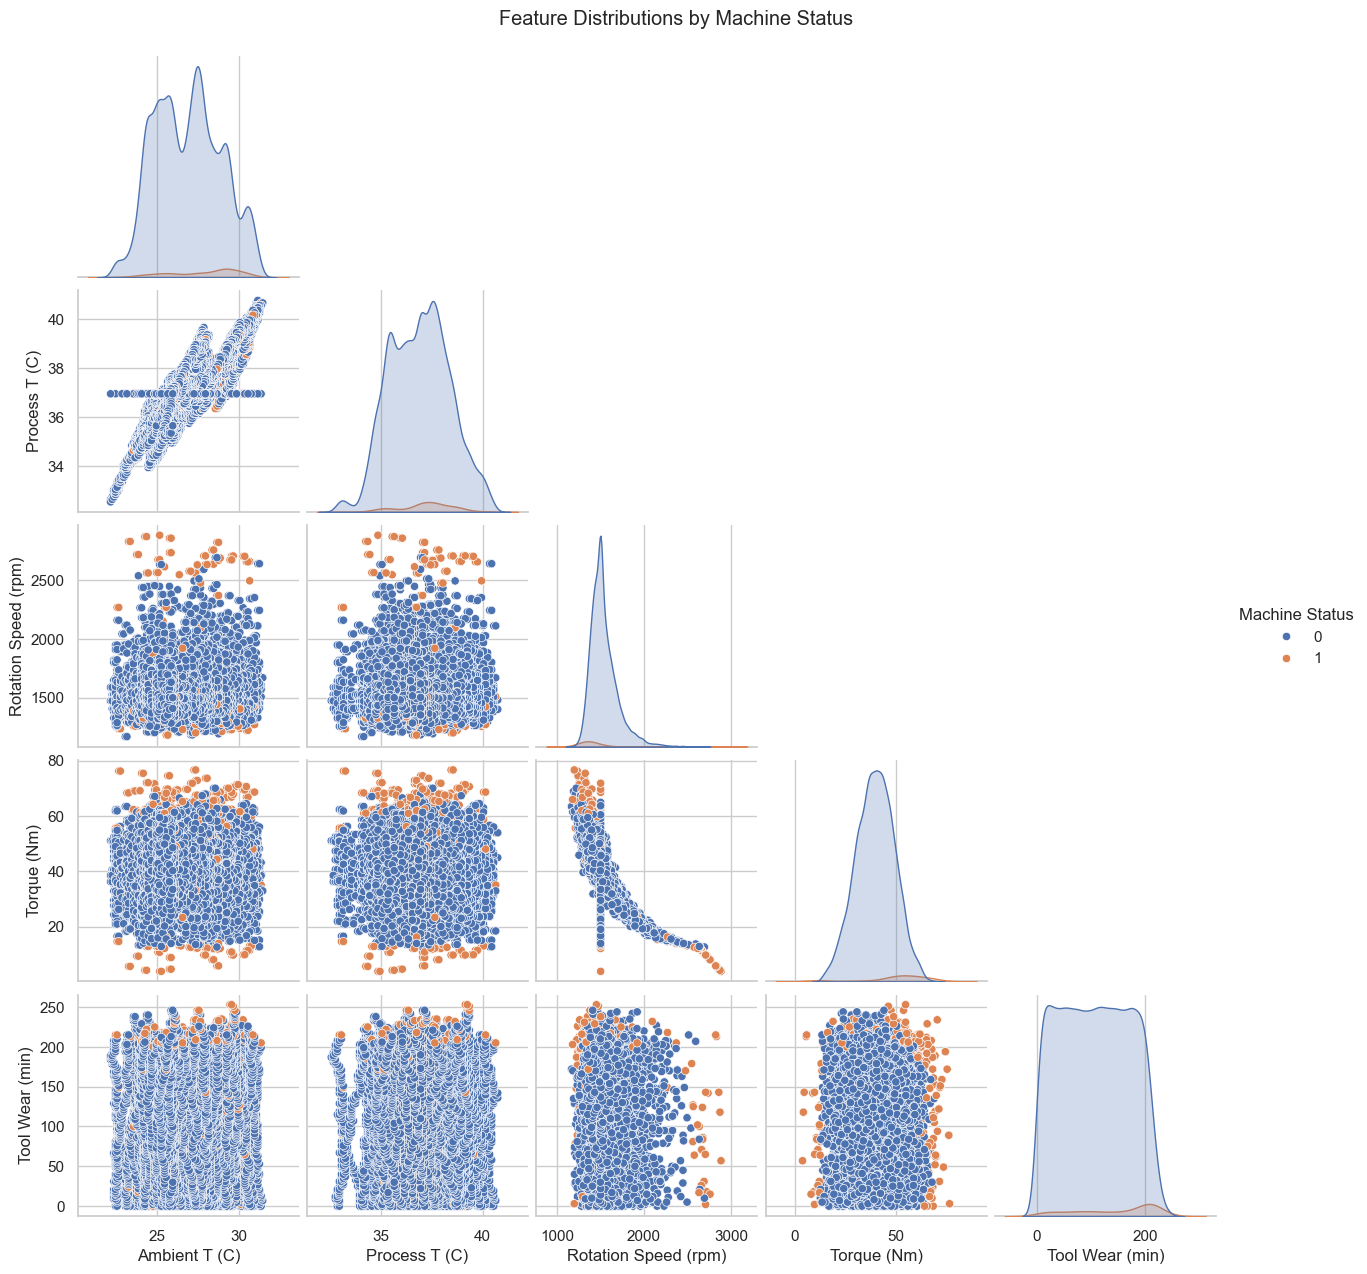

In [163]:
#Exploratory Data Analysis 
# Set plot style
sns.set(style="whitegrid")

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(factory_df_clean.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# Pairplot of selected features colored by Machine Status
selected_features = ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']
sns.pairplot(factory_df_clean[selected_features + ['Machine Status']], hue='Machine Status', corner=True)
plt.suptitle("Feature Distributions by Machine Status", y=1.02)
plt.savefig('pairplot.jpg')
plt.show()

In [164]:
#Features Selection
# Define features and target
X = factory_df_clean.drop(columns=['Unique ID', 'Product ID', 'Machine Status'])
y = factory_df_clean['Machine Status']
X


,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
0,1,24.95,35.45,1551.0,42.8,0
1,0,25.05,35.55,1408.0,46.3,3
2,0,24.95,35.35,1498.0,49.4,5
3,0,25.05,35.45,1433.0,39.5,7
4,0,25.05,35.55,1408.0,40.0,9
...,...,...,...,...,...,...
19995,1,25.75,35.35,1503.0,29.5,14
19996,2,25.85,35.35,1632.0,31.8,17
19997,1,25.95,36.95,1503.0,33.4,22
19998,2,25.95,35.65,1408.0,48.5,25


In [ ]:
# Train Random Forest Model for features importance

In [167]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

(16000, 6)
(16000,)


In [169]:
#Random Forest
model_RF=RandomForestClassifier(random_state=42)
model_RF.fit(X_train,y_train)
y_pred_RF=model_RF.predict(X_test)
RF_report=metrics.classification_report(y_test,y_pred_RF)
RF_matrix=metrics.confusion_matrix(y_test,y_pred_RF)

In [171]:
feature_importance = model_RF.feature_importances_

# Display features importance
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                Feature  Importance
4           Torque (Nm)    0.333273
3  Rotation Speed (rpm)    0.212685
5       Tool Wear (min)    0.171050
1         Ambient T (C)    0.134566
2         Process T (C)    0.122766
0               Quality    0.025660


# Since Random Forest features importance show that Process T (C) has rather low importance, 
#we can choose to remove Process (T) to reduce complicated model.

In [173]:
# Remove Process T (C) based on feature importance
X_cleaned = X.drop(columns=['Process T (C)'])

# Train-test split and model fitting
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)



(16000, 5)
(16000,)


## Model Training with Default Parameter
Classification Models used
1. SVC
2. KNN
3. Logistic Regression
4. Random Forest

In [175]:
# Feature scaling for SVC & KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [177]:
#SVC Model
model_SVC=SVC()
model_SVC.fit(X_train_scaled,y_train)
print(model_SVC)

y_pred_SVC=model_SVC.predict(X_test_scaled)
SVC_report=metrics.classification_report(y_test,y_pred_SVC)
SVC_matrix=metrics.confusion_matrix(y_test,y_pred_SVC)

SVC()


In [178]:
#KNN
model_K=KNeighborsClassifier()
model_K.fit(X_train_scaled,y_train)
y_pred_K=model_K.predict(X_test_scaled)
K_report = metrics.classification_report(y_test,y_pred_K)
K_matrix = metrics.confusion_matrix(y_test,y_pred_K)

In [181]:
#Logistic Regression
model_LR=LogisticRegression(max_iter=1000)
model_LR.fit(X_train,y_train)
print(model_LR)

y_pred_LR=model_LR.predict(X_test)
LR_report=metrics.classification_report(y_test,y_pred_LR)
LR_matrix=metrics.confusion_matrix(y_test,y_pred_LR)


LogisticRegression(max_iter=1000)


In [183]:
#Random Forest
model_RF=RandomForestClassifier(random_state=42)
model_RF.fit(X_train,y_train)
y_pred_RF=model_RF.predict(X_test)
RF_report=metrics.classification_report(y_test,y_pred_RF)
RF_matrix=metrics.confusion_matrix(y_test,y_pred_RF)

## Model Evaluation
based on CV scores/classification report and confusion matrix, random forest showed the best results.
Hence Random Forest Model Chosen

In [185]:
#To compare the models
    
print(f"===SVC===")
print(SVC_report)
print(SVC_matrix)

print(f"\n===KNN===")
print(K_report)
print(K_matrix)

    
print(f"\n===Logistic Regression===")

print(LR_report)
print(LR_matrix)

print(f"\n===Random Forest===")
print(RF_report)
print(RF_matrix)
print("\n")

===SVC===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3852
           1       0.98      0.29      0.45       148

    accuracy                           0.97      4000
   macro avg       0.98      0.65      0.72      4000
weighted avg       0.97      0.97      0.97      4000

[[3851    1]
 [ 105   43]]

===KNN===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3852
           1       0.82      0.45      0.58       148

    accuracy                           0.98      4000
   macro avg       0.90      0.72      0.78      4000
weighted avg       0.97      0.98      0.97      4000

[[3838   14]
 [  82   66]]

===Logistic Regression===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3852
           1       0.82      0.19      0.31       148

    accuracy                           0.97      4000
   macro avg       0.90   

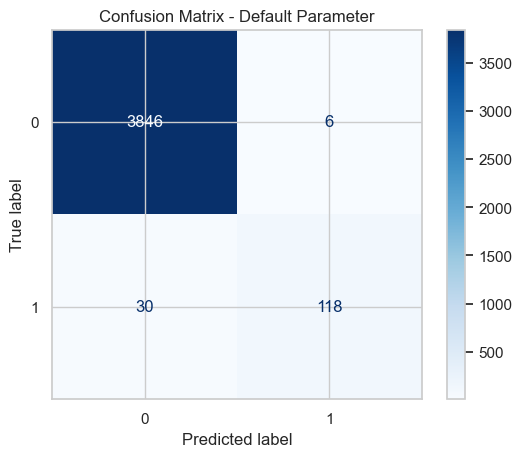

In [187]:
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=RF_matrix, display_labels=[0, 1])  # 0=Working, 1=Faulty
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Default Parameter")
plt.show()

In [92]:
#Comapre the CV scores

cv_scores_svc = cross_val_score(model_SVC, X, y, cv=5)
cv_scores_lg = cross_val_score(model_LR, X, y, cv=5)
cv_scores_rf = cross_val_score(model_RF, X, y, cv=5)
cv_scores_k = cross_val_score(model_K, X, y, cv=5)
print(f"SVC Cross-validation accuracy: {cv_scores_svc.mean():.2f}")
print(f"KNeighborsClassifier Forest Cross-validation accuracy: {cv_scores_k.mean():.2f}")
print(f"Logistic Regression Cross-validation accuracy: {cv_scores_lg.mean():.2f}")
print(f"Random Forest Cross-validation accuracy: {cv_scores_rf.mean():.2f}")

SVC Cross-validation accuracy: 0.97
KNeighborsClassifier Forest Cross-validation accuracy: 0.97
Logistic Regression Cross-validation accuracy: 0.97
Random Forest Cross-validation accuracy: 0.99


## Parameter Tuning for Random Forest

Random Forest chosen for parameter tuning

In [100]:
#random forest has the best CV score
model_RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [102]:
# Hyperparameter tuning for Random Forest
hyperparameter_space = {'n_estimators': [10,100], 'max_depth': [None,10,20]}
print(hyperparameter_space)

# define grid search , 10-fold cross validation
grid_rf = GridSearchCV(estimator=model_RF, param_grid=hyperparameter_space, cv=10, scoring='accuracy') 
grid_rf.fit(X_train, y_train) 

print('The best n_estimators:', grid_rf.best_estimator_.n_estimators) 
print('The best max_depth:', grid_rf.best_estimator_.max_depth) 
        

{'n_estimators': [10, 100], 'max_depth': [None, 10, 20]}
The best n_estimators: 100
The best max_depth: None


In [189]:
# Use the best model to make predictions
best_rf_model = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_rf_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_tuned))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3852
           1       1.00      0.97      0.98       148

    accuracy                           1.00      4000
   macro avg       1.00      0.98      0.99      4000
weighted avg       1.00      1.00      1.00      4000

Confusion Matrix:
 [[3852    0]
 [   5  143]]


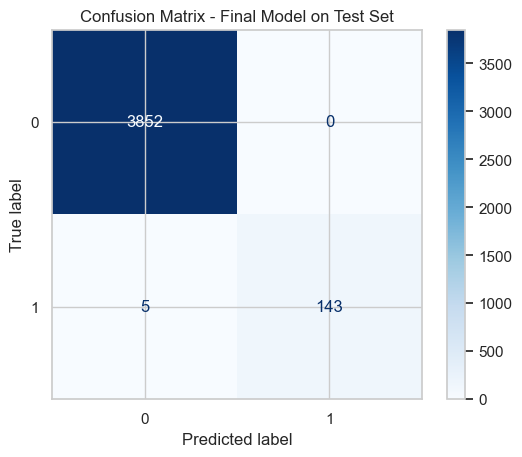

In [191]:
# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf_tuned), display_labels=grid_rf.best_estimator_.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Final Model on Test Set")
plt.show()
